In [1]:
import os
import site
import sqlite3
import sys
import warnings
from time import sleep

import logzero
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from logzero import logger
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import SARIMAX, VAR, acf, adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.tools import diff
from tqdm import tqdm_notebook as tqdm
from yaml import dump, load, safe_load

In [2]:
plt.rcParams["figure.figsize"] = 30, 25
plt.rcParams["ytick.labelsize"] = 11
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelpad"] = 12
plt.rcParams["axes.xmargin"] = 0.01
plt.rcParams["axes.ymargin"] = 0.01

In [3]:
log_path = "logs/"
log_file = "ts_arima.log"

logzero.logfile(log_path + log_file, maxBytes=1e6, backupCount=5, disableStderrLogger=True)
logger.info(f"{log_path}, {log_file}\n")

In [4]:
sys.path.append("../../sql")
import queries

In [5]:
configs = None
try:
    with open("../configs/config.yml", "r") as config_in:
        configs = load(config_in, Loader=yaml.SafeLoader)
        logger.info(f"{configs}\n")
except:
    logger.error(f"config file open failure.")
    exit(1)

cfg_vars = configs["url_variables"]
logger.info(f"variables: {cfg_vars}\n")

years = configs["request_years"]
logger.info(f"years: {years}\n")

db_path = configs["file_paths"]["db_path"]

city = configs["location_info"]["city"]
state = configs["location_info"]["state"]
db_file = city + "-" + state + ".db"

db_table1 = configs["table_names"]["db_table1"]
db_table2 = configs["table_names"]["db_table2"]

logger.info(f"{db_path}, {db_file}")

nrows = configs["num_rows"][0]
logger.info(f"number of rows: {nrows}\n")

In [6]:
conn = sqlite3.connect(db_path + db_file)
cursor = conn.cursor()

In [7]:
cursor.execute(queries.select_distinct_zips)
distinct_zipcodes = cursor.fetchall()
distinct_zipcodes = [z[0] for z in distinct_zipcodes]
logger.info(f"distinct zip codes:\n{distinct_zipcodes}")
print(distinct_zipcodes)

['91708']


In [8]:
zipcode_index = 0
params = {"zipcode": distinct_zipcodes[zipcode_index]}

select_nsr_rows = f"""
SELECT date_time,
-- year, month, day, 
-- zipcode,
-- Clearsky_DHI, DHI,
Clearsky_DNI, DNI,
Clearsky_GHI, GHI,
Temperature,
Relative_Humidity,
Precipitable_Water,
-- Wind_Direction,
Wind_Speed
from nsrdb
where zipcode = :zipcode
-- and not (month = 2 and day = 29)
-- and year = 2000
;
"""

df = pd.read_sql(
    select_nsr_rows,
    conn,
    params=params,
    index_col="date_time",
    parse_dates=["date_time"],
)

df.sort_index(axis=0, inplace=True)
columns = df.columns.tolist()
# df.head(5)

In [9]:
df_rsd = df.resample("D").mean().reset_index(drop=False)
df_rsd.set_index("date_time", inplace=True)
# df_rsd

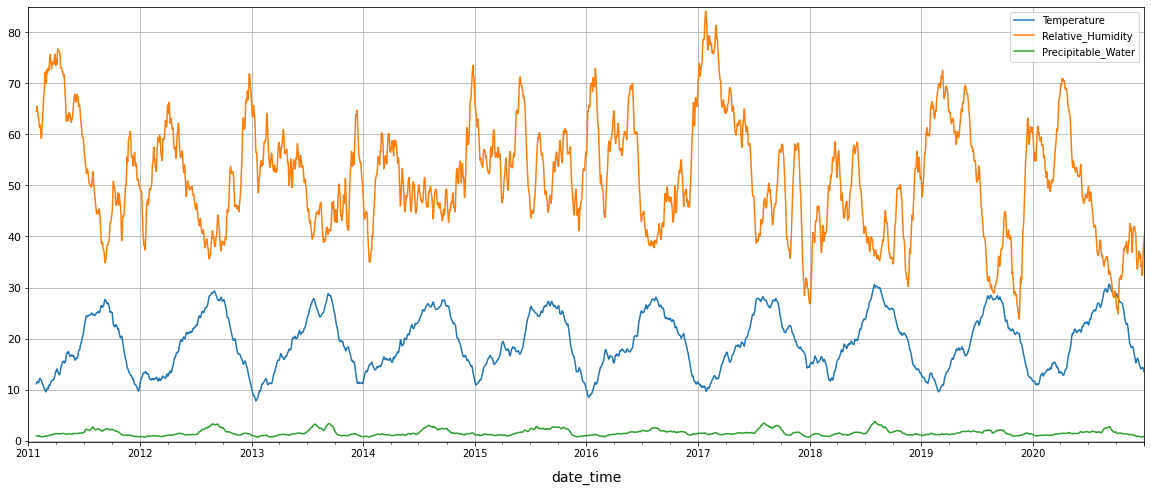

In [10]:
# # compares_ = ["Clearsky_DHI", "DHI"]
# compares_ = ["Wind_Speed", "Wind_Direction"]
compares_ = ["Temperature", "Relative_Humidity", "Precipitable_Water"]
# compares_ = ["Clearsky_GHI", "GHI"]
# compares_ = ["Clearsky_DNI", "DNI"]
# compares_ = ["GHI", "Relative_Humidity"]

# df.iloc[:35040][compares].rolling(365).mean().plot(figsize=(20, 8))
df_rsd.loc["2011-01-01":"2020-12-31"][compares_].rolling(28).mean().plot(figsize=(20, 8))
plt.grid()

In [11]:
df_rsm = df.resample("M").mean().reset_index(drop=False)
df_rsm.set_index("date_time", inplace=True)
# df_rsm

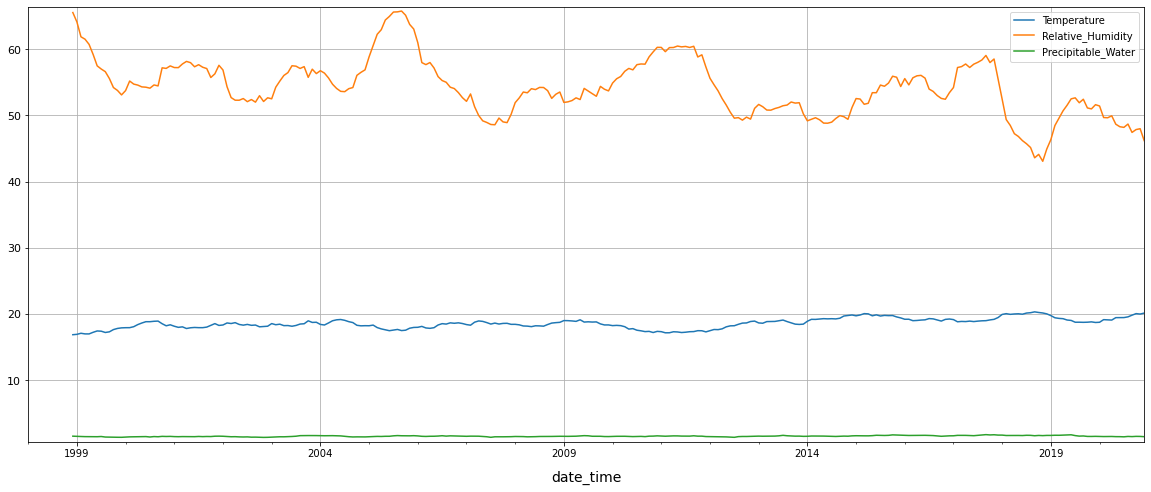

In [12]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_CG = ["Clearsky_GHI", "GHI"]
compares_CD = ["Clearsky_DNI", "DNI"]
compares_HG = ["Relative_Humidity", "GHI"]
compares_HD = ["Relative_Humidity", "DNI"]
compares_THP = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_rsm[compares_THP].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_CG].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_CD].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_A].rolling(12).mean().plot(figsize=(20, 8))
# df_rsm[compares_G + compares_D].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [13]:
# df_diff = df_rsm.diff(periods=12).dropna()

df_diff = df_rsm.copy()
for column in columns:
    df_diff[column] = diff(df_diff[column], 1, 1, 12)

df_diff.dropna(inplace=True)

# df_diff.head(12)2)

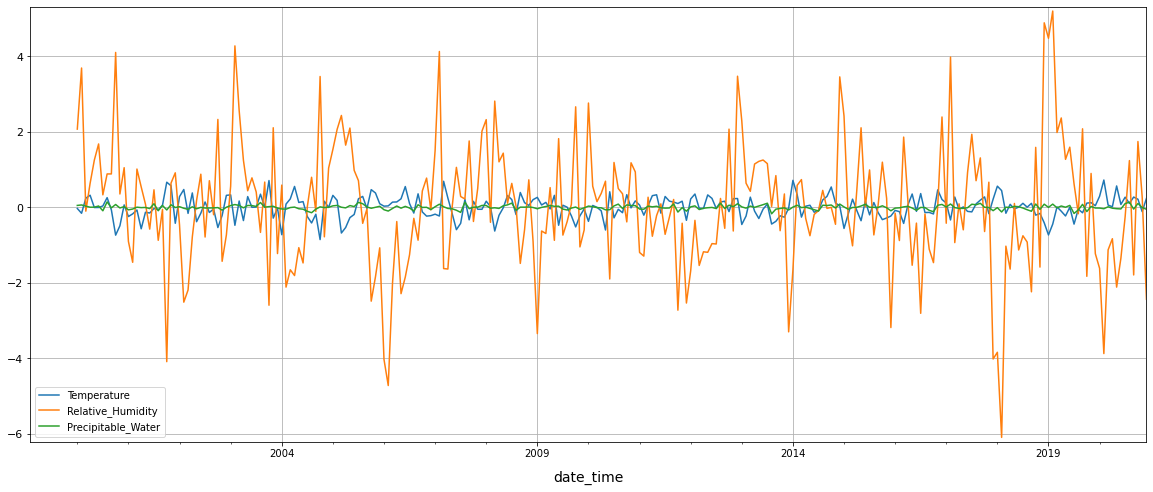

In [14]:
# # compares = ["Clearsky_DHI", "DHI"]
# # compares = ["Wind_Speed", "Wind_Direction"]

compares_HG = ["Relative_Humidity", "GHI"]
compares_CG = ["Clearsky_GHI", "GHI"]
compares_CD = ["Clearsky_DNI", "DNI"]
compares_THP = ["Temperature", "Relative_Humidity", "Precipitable_Water"]

df_diff[compares_THP].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_HG].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_CG].rolling(12).mean().plot(figsize=(20, 8))
# df_diff[compares_CD].rolling(12).mean().plot(figsize=(20, 8))
plt.grid()

In [19]:
adf_tests = []

for column in columns:
    adf_tests.append(adfuller(df_diff[column], autolag="AIC"))

for column, test in zip(columns, adf_tests):
    print(f"p-value: {test[1]}, lags: {test[2]} for {column}")

p-value: 5.172876851183793e-09, lags: 16 for Clearsky_DNI
p-value: 1.6690424186564485e-10, lags: 16 for DNI
p-value: 2.53847010895238e-09, lags: 16 for Clearsky_GHI
p-value: 4.835339506716251e-11, lags: 16 for GHI
p-value: 1.6361737605678158e-07, lags: 14 for Temperature
p-value: 2.3924221419536123e-10, lags: 16 for Relative_Humidity
p-value: 3.699476866649928e-12, lags: 16 for Precipitable_Water
p-value: 8.622377934789219e-10, lags: 15 for Wind_Speed


In [16]:
kpss_tests = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for column in columns:
        kpss_tests.append(kpss(df_diff[column], regression="ct", nlags="auto"))

for column, test in zip(columns, kpss_tests):
    print(f"p-value: {test[1]}, {test[2]} for {column}")

p-value: 0.1, 56 for Clearsky_DNI
p-value: 0.1, 55 for DNI
p-value: 0.015388893452602097, 101 for Clearsky_GHI
p-value: 0.1, 45 for GHI
p-value: 0.04998339708998931, 71 for Temperature
p-value: 0.1, 50 for Relative_Humidity
p-value: 0.1, 44 for Precipitable_Water
p-value: 0.1, 16 for Wind_Speed
